This notebook is for preparation data before an analysis

In [4]:
import numpy as np
import pandas as pd
import cooler
from cooltools.api.sample import sample
from cooltools.api.insulation import calculate_insulation_score
from cooltools.api.eigdecomp import eigs_cis
import bioframe

from matplotlib import pyplot as plt
import seaborn as sns

from glob import glob
from tqdm.notebook import tqdm
from natsort import natsorted
from os.path import basename, splitext
import os

# Hi-C

In [2]:
# #paths
# COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
# DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
# INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
# COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
# GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'

# RESOLUTION = 50000
# #FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
# #FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
# FILES = natsorted(glob('%s/nodiags/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
# #FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))

# #CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
# CLRS = [cooler.Cooler(p) for p in FILES]
# LBLS = [os.path.basename(p).split('.')[0] for p in FILES]

# print(LBLS, '\n', [round(c.info['sum']/10**6, 2) for c in CLRS], 'M')

['KO', 'adl', 'old', 'yng']


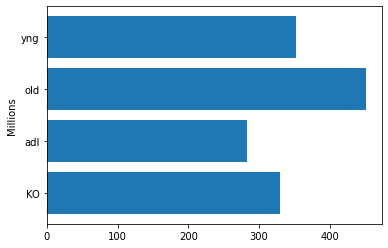

In [7]:
#paths
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
MERGED_COOLER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_coolers'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
MERGED_DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
TMP_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/tmp'

RESOLUTION = 2000
FILES = natsorted(glob('%s/*2000.mcool' % MERGED_COOLER_PATH))
CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
LBLS = [os.path.basename(p).split('.')[0] for p in FILES]
GROUPS = ['adl', 'KO', 'old', 'yng']

print(LBLS)
plt.figure(figsize=(6,4))
plt.barh(LBLS, [round(c.info['sum']/10**6, 2) for c in CLRS])
plt.ylabel('Millions');


In [15]:
# for c in CLRS:
#     pix = c.pixels()[:]
#     k = pix[(pix['bin1_id'] == pix['bin2_id']) | 
#         ((pix['bin1_id']+1) == pix['bin2_id']) ]['count'].sum() / pix['count'].sum()
#     print(k)

## coolers

In [10]:
#merge coolers using RESOLUTION as base resolution
resolutions = [2000, 4000, 10_000, 20_000, 50_000, 100_000, 200_000, 1_000_000]
remove_tmp = True
#extract coolers from initial .mcools
for c, l in zip(CLRS, LBLS):
    cooler.create_cooler('%s/%s_%d.cool' % (TMP_FOLDER_PATH, l, RESOLUTION),
                             bins=c.bins()[:],
                             pixels=c.pixels()[:],
                            )    
#merge coolers by groups
tmpFILES = natsorted(glob(TMP_FOLDER_PATH + '/*'))
for g in GROUPS:
    group = [f for f in tmpFILES if g in f]
    cooler.merge_coolers(MERGED_COOLER_PATH + '/%s_%d.cool' % (g, RESOLUTION), 
                         group, 
                         mergebuf=200_000_000)
#zoomify based on base RESOLUTION making .mcool files
tmpFILES = natsorted(glob(MERGED_COOLER_PATH + '/*.cool'))
for g in GROUPS:
    cooler.zoomify_cooler([f for f in tmpFILES if g in f], 
                          MERGED_COOLER_PATH + '/%s.%d.mcool' % (g, RESOLUTION), 
                          resolutions,
                          chunksize=100_000_000, nproc=20)
#erase tmp base files    
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)

#erase tmp folder   
for f in glob(TMP_FOLDER_PATH + '/*'):
    os.remove(f)

In [27]:
#os.system(f'cooler ls {mcool file} | xargs -n1 cooler balance {balance args}') # for dry run

# balancing
forbalancing = glob(MERGED_COOLER_PATH + '/*2000.mcool')
for mcool in forbalancing:
    os.system(f"cooler ls {mcool} | xargs -n1 cooler balance")

INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/KO.2000.mcool::/resolutions/2000"
INFO:cooler.balance:variance is 34491.17543182411
INFO:cooler.balance:variance is 15525.983015318603
INFO:cooler.balance:variance is 2730.2853032448484
INFO:cooler.balance:variance is 3422.027025980827
INFO:cooler.balance:variance is 1060.575766527889
INFO:cooler.balance:variance is 1129.697432519351
INFO:cooler.balance:variance is 465.39124089789857
INFO:cooler.balance:variance is 445.74154113590544
INFO:cooler.balance:variance is 218.79731434485998
INFO:cooler.balance:variance is 193.19674575336467
INFO:cooler.balance:variance is 106.65476054493874
INFO:cooler.balance:variance is 88.48896388885905
INFO:cooler.balance:variance is 52.93529084856304
INFO:cooler.balance:variance is 41.95173935445523
INFO:cooler.balance:variance is 26.51312889605005
INFO:cooler.balance:variance is 20.338340326420933
INFO:cooler.balance:variance is 13.345503110715294
INFO:cooler.balance:

INFO:cooler.balance:variance is 1.866455731649358
INFO:cooler.balance:variance is 1.283864513174043
INFO:cooler.balance:variance is 0.9028282832934748
INFO:cooler.balance:variance is 0.6234773864020695
INFO:cooler.balance:variance is 0.4371341674119478
INFO:cooler.balance:variance is 0.3027021789436024
INFO:cooler.balance:variance is 0.2118041129305766
INFO:cooler.balance:variance is 0.1469459149711528
INFO:cooler.balance:variance is 0.10267999312559203
INFO:cooler.balance:variance is 0.07133160410192527
INFO:cooler.balance:variance is 0.04979825584792111
INFO:cooler.balance:variance is 0.03462676054734425
INFO:cooler.balance:variance is 0.024159081954903093
INFO:cooler.balance:variance is 0.01680976511360497
INFO:cooler.balance:variance is 0.011723492201781746
INFO:cooler.balance:variance is 0.008160941049325326
INFO:cooler.balance:variance is 0.0056901523174333205
INFO:cooler.balance:variance is 0.003962350095219297
INFO:cooler.balance:variance is 0.002762272862570136
INFO:cooler.bal

INFO:cooler.balance:variance is 0.04330005384257957
INFO:cooler.balance:variance is 0.029996822884393527
INFO:cooler.balance:variance is 0.020809441188914157
INFO:cooler.balance:variance is 0.014420416503598097
INFO:cooler.balance:variance is 0.010002734335586582
INFO:cooler.balance:variance is 0.006933229225783536
INFO:cooler.balance:variance is 0.004808979648202684
INFO:cooler.balance:variance is 0.0033338548895332537
INFO:cooler.balance:variance is 0.0023123545305202362
INFO:cooler.balance:variance is 0.0016032775186916137
INFO:cooler.balance:variance is 0.0011120286167843362
INFO:cooler.balance:variance is 0.0007711142242992738
INFO:cooler.balance:variance is 0.0005348492932548062
INFO:cooler.balance:variance is 0.00037091438864165653
INFO:cooler.balance:variance is 0.0002572737716649409
INFO:cooler.balance:variance is 0.00017843108685776038
INFO:cooler.balance:variance is 0.00012376664066076788
INFO:cooler.balance:variance is 8.584326057597802e-05
INFO:cooler.balance:variance is 5

INFO:cooler.balance:variance is 4645.725758544547
INFO:cooler.balance:variance is 3063.92382834041
INFO:cooler.balance:variance is 2797.224399646828
INFO:cooler.balance:variance is 1913.666309220521
INFO:cooler.balance:variance is 1697.7113715050916
INFO:cooler.balance:variance is 1196.21525213393
INFO:cooler.balance:variance is 1036.5412111785647
INFO:cooler.balance:variance is 747.7567500256049
INFO:cooler.balance:variance is 635.6790041812216
INFO:cooler.balance:variance is 467.2396326076656
INFO:cooler.balance:variance is 391.1365812730908
INFO:cooler.balance:variance is 291.7883402820487
INFO:cooler.balance:variance is 241.26571384576846
INFO:cooler.balance:variance is 182.10551427814642
INFO:cooler.balance:variance is 149.09765045832685
INFO:cooler.balance:variance is 113.58320608057291
INFO:cooler.balance:variance is 92.26878917392067
INFO:cooler.balance:variance is 70.80519627090246
INFO:cooler.balance:variance is 57.16096213537182
INFO:cooler.balance:variance is 44.11702198180

INFO:cooler.balance:variance is 3.363699905455573e-05
INFO:cooler.balance:variance is 2.0829510638424892e-05
INFO:cooler.balance:variance is 1.289854479845231e-05
INFO:cooler.balance:variance is 7.987349877212065e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/adl.2000.mcool::/resolutions/2000"
INFO:cooler.balance:variance is 24809.658455253597
INFO:cooler.balance:variance is 10779.54469810041
INFO:cooler.balance:variance is 2514.5796027545125
INFO:cooler.balance:variance is 2715.130071868104
INFO:cooler.balance:variance is 974.2809080843452
INFO:cooler.balance:variance is 930.1943661975478
INFO:cooler.balance:variance is 411.00519787694344
INFO:cooler.balance:variance is 361.7079998796719
INFO:cooler.balance:variance is 183.1095947947467
INFO:cooler.balance:variance is 151.1738583294069
INFO:cooler.balance:variance is 84.26105209395337
INFO:cooler.balance:variance is 66.20887831841134
INFO:cooler.balance:variance is 39.50072989549223
INFO:coo

INFO:cooler.balance:variance is 0.07329928968680476
INFO:cooler.balance:variance is 0.04947887066694188
INFO:cooler.balance:variance is 0.03332959593759278
INFO:cooler.balance:variance is 0.022497400924123664
INFO:cooler.balance:variance is 0.015165682930064303
INFO:cooler.balance:variance is 0.010237612884544917
INFO:cooler.balance:variance is 0.006905274842327731
INFO:cooler.balance:variance is 0.004662112583009153
INFO:cooler.balance:variance is 0.0031460906383082325
INFO:cooler.balance:variance is 0.0021244917514596793
INFO:cooler.balance:variance is 0.001434222939789608
INFO:cooler.balance:variance is 0.000968703515922539
INFO:cooler.balance:variance is 0.0006541863088485989
INFO:cooler.balance:variance is 0.00044194581600002315
INFO:cooler.balance:variance is 0.0002985453723252661
INFO:cooler.balance:variance is 0.00020173020445964258
INFO:cooler.balance:variance is 0.00013631034840812082
INFO:cooler.balance:variance is 9.212554243677599e-05
INFO:cooler.balance:variance is 6.2264

INFO:cooler.balance:variance is 3489.474404966785
INFO:cooler.balance:variance is 3449.362905677872
INFO:cooler.balance:variance is 1952.5542966474068
INFO:cooler.balance:variance is 1814.7652282976135
INFO:cooler.balance:variance is 1094.6772194589555
INFO:cooler.balance:variance is 968.8689477120564
INFO:cooler.balance:variance is 614.3178756680309
INFO:cooler.balance:variance is 523.3051401410399
INFO:cooler.balance:variance is 344.9551654738305
INFO:cooler.balance:variance is 285.27807405469304
INFO:cooler.balance:variance is 193.8080789838175
INFO:cooler.balance:variance is 156.68236285917584
INFO:cooler.balance:variance is 108.95936643505222
INFO:cooler.balance:variance is 86.57865280065302
INFO:cooler.balance:variance is 61.30687313019924
INFO:cooler.balance:variance is 48.082201877901895
INFO:cooler.balance:variance is 34.528414703015756
INFO:cooler.balance:variance is 26.815954964080547
INFO:cooler.balance:variance is 19.46838355204911
INFO:cooler.balance:variance is 15.009696

INFO:cooler.balance:variance is 7.608244159014447e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/adl.2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 563096928.0437493
INFO:cooler.balance:variance is 67721223699.1202
INFO:cooler.balance:variance is 304568287.5257012
INFO:cooler.balance:variance is 6518125446.239255
INFO:cooler.balance:variance is 169135748.98724523
INFO:cooler.balance:variance is 892616253.1896101
INFO:cooler.balance:variance is 77000125.16290666
INFO:cooler.balance:variance is 173775830.8758723
INFO:cooler.balance:variance is 31124861.56970736
INFO:cooler.balance:variance is 41818624.32661914
INFO:cooler.balance:variance is 11774670.54864563
INFO:cooler.balance:variance is 11385026.514281806
INFO:cooler.balance:variance is 4246060.73901735
INFO:cooler.balance:variance is 3331561.708144728
INFO:cooler.balance:variance is 1475884.4692320717
INFO:cooler.balance:variance is 1017219.3770652077
INFO:cooler.balance

INFO:cooler.balance:variance is 0.9941847755327272
INFO:cooler.balance:variance is 0.6989116481004426
INFO:cooler.balance:variance is 0.4976410721070301
INFO:cooler.balance:variance is 0.35081454110754234
INFO:cooler.balance:variance is 0.2495324690261781
INFO:cooler.balance:variance is 0.17626364618788268
INFO:cooler.balance:variance is 0.12529654349238337
INFO:cooler.balance:variance is 0.08863699673147142
INFO:cooler.balance:variance is 0.06298396528391928
INFO:cooler.balance:variance is 0.044604576081719076
INFO:cooler.balance:variance is 0.03168876863345745
INFO:cooler.balance:variance is 0.02245992161350609
INFO:cooler.balance:variance is 0.015954801996062157
INFO:cooler.balance:variance is 0.011315156329378809
INFO:cooler.balance:variance is 0.008037666035695473
INFO:cooler.balance:variance is 0.005702974762348995
INFO:cooler.balance:variance is 0.004051115751902395
INFO:cooler.balance:variance is 0.0028754196248783124
INFO:cooler.balance:variance is 0.002042623675193817
INFO:co

INFO:cooler.balance:variance is 0.0044755537190459965
INFO:cooler.balance:variance is 0.003084429084053769
INFO:cooler.balance:variance is 0.0021246987029733422
INFO:cooler.balance:variance is 0.0014641856851955934
INFO:cooler.balance:variance is 0.0010086835970639114
INFO:cooler.balance:variance is 0.000695080894569855
INFO:cooler.balance:variance is 0.00047887322697425893
INFO:cooler.balance:variance is 0.00032998171027315157
INFO:cooler.balance:variance is 0.00022734985171508706
INFO:cooler.balance:variance is 0.00015665990845962512
INFO:cooler.balance:variance is 0.00010793879279572644
INFO:cooler.balance:variance is 7.437688358160333e-05
INFO:cooler.balance:variance is 5.12470963533117e-05
INFO:cooler.balance:variance is 3.531255630240279e-05
INFO:cooler.balance:variance is 2.433154833159123e-05
INFO:cooler.balance:variance is 1.676604432811287e-05
INFO:cooler.balance:variance is 1.1552577394033178e-05
INFO:cooler.balance:variance is 7.960524943120668e-06
INFO:cooler.cli.balance:B

INFO:cooler.balance:variance is 1.1703421585499367
INFO:cooler.balance:variance is 0.9221367263652736
INFO:cooler.balance:variance is 0.7344375704903683
INFO:cooler.balance:variance is 0.5795181405001804
INFO:cooler.balance:variance is 0.46125472384206473
INFO:cooler.balance:variance is 0.3643989573375639
INFO:cooler.balance:variance is 0.2898942359896988
INFO:cooler.balance:variance is 0.22925262050327838
INFO:cooler.balance:variance is 0.1823158218799799
INFO:cooler.balance:variance is 0.1443004753961881
INFO:cooler.balance:variance is 0.11472865067969056
INFO:cooler.balance:variance is 0.09087136918016879
INFO:cooler.balance:variance is 0.07223734101491122
INFO:cooler.balance:variance is 0.05725088480774771
INFO:cooler.balance:variance is 0.04550676001672285
INFO:cooler.balance:variance is 0.03608473186382845
INFO:cooler.balance:variance is 0.028681264971378354
INFO:cooler.balance:variance is 0.02275315312551852
INFO:cooler.balance:variance is 0.018084831918621636
INFO:cooler.balanc

INFO:cooler.balance:variance is 35.617998345812154
INFO:cooler.balance:variance is 31.945459316261342
INFO:cooler.balance:variance is 27.97484823487155
INFO:cooler.balance:variance is 25.05517157015772
INFO:cooler.balance:variance is 21.970012225656948
INFO:cooler.balance:variance is 19.652578242084463
INFO:cooler.balance:variance is 17.252865584049296
INFO:cooler.balance:variance is 15.416000342561777
INFO:cooler.balance:variance is 13.547655746950928
INFO:cooler.balance:variance is 12.093457285016052
INFO:cooler.balance:variance is 10.63756497207865
INFO:cooler.balance:variance is 9.487521695498732
INFO:cooler.balance:variance is 8.35214996146813
INFO:cooler.balance:variance is 7.443478506671175
INFO:cooler.balance:variance is 6.557447621074799
INFO:cooler.balance:variance is 5.840063376949538
INFO:cooler.balance:variance is 5.148184309153269
INFO:cooler.balance:variance is 4.582215764011797
INFO:cooler.balance:variance is 4.041643662799729
INFO:cooler.balance:variance is 3.595406456

INFO:cooler.balance:variance is 63.87817709081736
INFO:cooler.balance:variance is 43.94833087259782
INFO:cooler.balance:variance is 30.21598956591369
INFO:cooler.balance:variance is 20.78669464643298
INFO:cooler.balance:variance is 14.293241624849275
INFO:cooler.balance:variance is 9.8322272216712
INFO:cooler.balance:variance is 6.761347778895554
INFO:cooler.balance:variance is 4.650893092826794
INFO:cooler.balance:variance is 3.1984782067351967
INFO:cooler.balance:variance is 2.200060864231624
INFO:cooler.balance:variance is 1.5130737004905206
INFO:cooler.balance:variance is 1.0407437980175842
INFO:cooler.balance:variance is 0.7157846794288374
INFO:cooler.balance:variance is 0.49233580133785826
INFO:cooler.balance:variance is 0.33861758545565446
INFO:cooler.balance:variance is 0.23290867488501799
INFO:cooler.balance:variance is 0.1601919489028449
INFO:cooler.balance:variance is 0.11018315427302379
INFO:cooler.balance:variance is 0.07578361255388974
INFO:cooler.balance:variance is 0.05

INFO:cooler.balance:variance is 0.236240722213475
INFO:cooler.balance:variance is 0.17484205973980202
INFO:cooler.balance:variance is 0.12886220489359201
INFO:cooler.balance:variance is 0.09535478431824462
INFO:cooler.balance:variance is 0.07034703957188426
INFO:cooler.balance:variance is 0.05205173507266004
INFO:cooler.balance:variance is 0.03843016923247196
INFO:cooler.balance:variance is 0.02843572868127404
INFO:cooler.balance:variance is 0.021007126951391043
INFO:cooler.balance:variance is 0.015544627269450871
INFO:cooler.balance:variance is 0.011489341733606849
INFO:cooler.balance:variance is 0.008502400501307978
INFO:cooler.balance:variance is 0.006286777603661849
INFO:cooler.balance:variance is 0.0046527872449920165
INFO:cooler.balance:variance is 0.0034414346193541957
INFO:cooler.balance:variance is 0.0025472157425152206
INFO:cooler.balance:variance is 0.0018845458052498046
INFO:cooler.balance:variance is 0.001394999804248744
INFO:cooler.balance:variance is 0.001032309139687378

INFO:cooler.balance:variance is 0.9429876642015238
INFO:cooler.balance:variance is 0.670775236009813
INFO:cooler.balance:variance is 0.4760059919323885
INFO:cooler.balance:variance is 0.3385994557468923
INFO:cooler.balance:variance is 0.24047600945188127
INFO:cooler.balance:variance is 0.17107909856791698
INFO:cooler.balance:variance is 0.1215823948290431
INFO:cooler.balance:variance is 0.08651225921667427
INFO:cooler.balance:variance is 0.06151692667207094
INFO:cooler.balance:variance is 0.043782601279786726
INFO:cooler.balance:variance is 0.03114787487864324
INFO:cooler.balance:variance is 0.022174067011732863
INFO:cooler.balance:variance is 0.01578181110394727
INFO:cooler.balance:variance is 0.011237982751693394
INFO:cooler.balance:variance is 0.008001379610589747
INFO:cooler.balance:variance is 0.005699174553878636
INFO:cooler.balance:variance is 0.004059176187534471
INFO:cooler.balance:variance is 0.0028920058745490486
INFO:cooler.balance:variance is 0.0020604486537315232
INFO:coo

INFO:cooler.balance:variance is 1.0468382851350537e-05
INFO:cooler.balance:variance is 8.624262516314568e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_coolers/old.2000.mcool::/resolutions/100000"
INFO:cooler.balance:variance is 35755040.949466944
INFO:cooler.balance:variance is 3843712963.597819
INFO:cooler.balance:variance is 17168485.62664494
INFO:cooler.balance:variance is 481171090.4230401
INFO:cooler.balance:variance is 8509190.30435856
INFO:cooler.balance:variance is 92477375.55613425
INFO:cooler.balance:variance is 4406819.932087987
INFO:cooler.balance:variance is 24892214.469882753
INFO:cooler.balance:variance is 2321659.9691278366
INFO:cooler.balance:variance is 8345100.77500016
INFO:cooler.balance:variance is 1218547.2225553927
INFO:cooler.balance:variance is 3238212.588313624
INFO:cooler.balance:variance is 638276.3533400053
INFO:cooler.balance:variance is 1392196.5653940882
INFO:cooler.balance:variance is 337670.8151286996
INFO:cooler.ba

INFO:cooler.balance:variance is 151801.59299766368
INFO:cooler.balance:variance is 69697.6197757515
INFO:cooler.balance:variance is 92930.31481380743
INFO:cooler.balance:variance is 46635.80228385506
INFO:cooler.balance:variance is 58010.70055645302
INFO:cooler.balance:variance is 31452.52167017853
INFO:cooler.balance:variance is 36793.03404831548
INFO:cooler.balance:variance is 21324.63784874111
INFO:cooler.balance:variance is 23640.625420927478
INFO:cooler.balance:variance is 14506.965332099075
INFO:cooler.balance:variance is 15351.615681526588
INFO:cooler.balance:variance is 9889.3801968066
INFO:cooler.balance:variance is 10055.627617985123
INFO:cooler.balance:variance is 6749.526740201591
INFO:cooler.balance:variance is 6633.436697204605
INFO:cooler.balance:variance is 4609.309673130987
INFO:cooler.balance:variance is 4401.325283859127
INFO:cooler.balance:variance is 3148.4399989429057
INFO:cooler.balance:variance is 2934.188231523213
INFO:cooler.balance:variance is 2150.5680425363

INFO:cooler.balance:variance is 320687.1869607166
INFO:cooler.balance:variance is 273738.19732644863
INFO:cooler.balance:variance is 196209.4970962038
INFO:cooler.balance:variance is 164268.9181129146
INFO:cooler.balance:variance is 119920.32004341726
INFO:cooler.balance:variance is 98879.42012044135
INFO:cooler.balance:variance is 73231.4705542544
INFO:cooler.balance:variance is 59663.58400888436
INFO:cooler.balance:variance is 44690.441839255116
INFO:cooler.balance:variance is 36069.95911087539
INFO:cooler.balance:variance is 27258.8372193051
INFO:cooler.balance:variance is 21839.38728453123
INFO:cooler.balance:variance is 16619.823208812366
INFO:cooler.balance:variance is 13239.011793102696
INFO:cooler.balance:variance is 10130.051163262013
INFO:cooler.balance:variance is 8033.071156229729
INFO:cooler.balance:variance is 6172.968917193926
INFO:cooler.balance:variance is 4877.890386470901
INFO:cooler.balance:variance is 3760.952624824497
INFO:cooler.balance:variance is 2963.728485782

In [10]:
#pure downsampling procedure
# if not os.path.exists(DOWNSAMPLED_FOLDER_PATH):
#     os.makedirs(DOWNSAMPLED_FOLDER_PATH)

# MIN_SUM = min([c.info['sum'] for c in CLRS])
# print('Minimal count sum:', MIN_SUM)
# for l, c in zip(LBLS, CLRS):
#     sample(c, '%s/%s_down_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, RESOLUTION), 
#                   count=MIN_SUM//1000*1000, 
#                   exact=False,
#                   chunksize=100_000_000)

INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_2_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_3_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_male_1_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:coole

In [3]:
#downsampling procedure with first m diagonals removal
# if not os.path.exists(DOWNSAMPLED_FOLDER_PATH):
#     os.makedirs(DOWNSAMPLED_FOLDER_PATH)

# resolutions = [2000, 4000, 10_000, 20_000, 50_000, 100_000, 200_000, 1_000_000]
# m = 2 #number of diags for removing
# remove_tmp = True

# #erasing m diags
# for l, c in zip(LBLS, CLRS):
#     pix = c.pixels()[:]
#     for k in range(m):
#         pix.loc[(pix.bin1_id + k) == (pix.bin2_id), 'count'] = 0
#     cooler.create_cooler('%s/%s_no_%d_diags_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION),
#                          bins=c.bins()[:],
#                          pixels=pix,
#                         )
# tmpFILES = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*diags_*.cool'))
# tmpCLRS = [cooler.Cooler(p) for p in tmpFILES]

# #downsampling
# MIN_SUM = min([c.info['sum'] for c in tmpCLRS])
# print('Minimal count sum:', MIN_SUM)
# for l, c in zip(LBLS, tmpCLRS):
#     sample(c, '%s/%s_down_no_%d_diags_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION), 
#                   count=MIN_SUM//1000*1000, 
#                   exact=False,
#                   chunksize=100_000_000)
# if remove_tmp: 
#     for f in tmpFILES:
#         os.remove(f)
        
# tmpFILES = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*_down*diags*.cool'))
# for f, l in zip(tmpFILES, LBLS):
#     cooler.zoomify_cooler([f], 
#                       DOWNSAMPLED_FOLDER_PATH + '/%s_down_no_%d_diag_%d.mcool' % (l, m, RESOLUTION), 
#                       resolutions,
#                       chunksize=100_000_000, nproc=20)
# if remove_tmp: 
#     for f in tmpFILES:
#         os.remove(f)
        
#os.system(f'cooler ls {mcool file} | xargs -n1 cooler balance {balance args}') # for dry run

# # balancing
# forbalancing = glob(DOWNSAMPLED_FOLDER_PATH + '/*%s.mcool' % RESOLUTION)
# for mcool in forbalancing:
#     os.system(f"cooler ls {mcool} | xargs -n1 cooler balance --force")

INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/adl_f_2_down_no_2_diag_2000.mcool::/resolutions/2000"
INFO:cooler.balance:variance is 1771.6153501330634
INFO:cooler.balance:variance is 327.80047050775147
INFO:cooler.balance:variance is 140.53021112471228
INFO:cooler.balance:variance is 88.4780474757039
INFO:cooler.balance:variance is 45.46678878733529
INFO:cooler.balance:variance is 30.153147503531965
INFO:cooler.balance:variance is 16.254133132358003
INFO:cooler.balance:variance is 11.137401342665694
INFO:cooler.balance:variance is 6.28687705328809
INFO:cooler.balance:variance is 4.379204606854856
INFO:cooler.balance:variance is 2.585525201205269
INFO:cooler.balance:variance is 1.809109379392524
INFO:cooler.balance:variance is 1.1103925904198475
INFO:cooler.balance:variance is 0.7754951069812728
INFO:cooler.balance:variance is 0.4907661193701923
INFO:cooler.balance:variance is 0.3412891056715274
INFO:cooler.balance:variance is 0.22094113354686631
IN

INFO:cooler.balance:variance is 63.22430896601967
INFO:cooler.balance:variance is 37.37924513399994
INFO:cooler.balance:variance is 24.429063602122138
INFO:cooler.balance:variance is 14.85307819772477
INFO:cooler.balance:variance is 9.65502023356917
INFO:cooler.balance:variance is 5.981259554158422
INFO:cooler.balance:variance is 3.871194007084059
INFO:cooler.balance:variance is 2.42787437947714
INFO:cooler.balance:variance is 1.5665441260778739
INFO:cooler.balance:variance is 0.9904131165324598
INFO:cooler.balance:variance is 0.6377558891750306
INFO:cooler.balance:variance is 0.40533591676217556
INFO:cooler.balance:variance is 0.260679780713079
INFO:cooler.balance:variance is 0.16625433837762424
INFO:cooler.balance:variance is 0.10684243190552656
INFO:cooler.balance:variance is 0.06829783413142217
INFO:cooler.balance:variance is 0.0438732989485261
INFO:cooler.balance:variance is 0.028088602946019912
INFO:cooler.balance:variance is 0.01803993292519094
INFO:cooler.balance:variance is 0.

INFO:cooler.balance:variance is 1.0217902151373235
INFO:cooler.balance:variance is 0.5786268987732178
INFO:cooler.balance:variance is 0.32714860779034477
INFO:cooler.balance:variance is 0.18524514799770728
INFO:cooler.balance:variance is 0.10480138339089551
INFO:cooler.balance:variance is 0.05934210915537846
INFO:cooler.balance:variance is 0.03358529128083538
INFO:cooler.balance:variance is 0.01901742617649907
INFO:cooler.balance:variance is 0.010765637939418727
INFO:cooler.balance:variance is 0.006096115220143852
INFO:cooler.balance:variance is 0.0034514736712363495
INFO:cooler.balance:variance is 0.0019544700201169153
INFO:cooler.balance:variance is 0.001106675646941631
INFO:cooler.balance:variance is 0.0006266926009504373
INFO:cooler.balance:variance is 0.00035487175367775317
INFO:cooler.balance:variance is 0.00020096187496702634
INFO:cooler.balance:variance is 0.00011380126251697272
INFO:cooler.balance:variance is 6.444595339504188e-05
INFO:cooler.balance:variance is 3.649555115551

INFO:cooler.balance:variance is 0.0017358406035297878
INFO:cooler.balance:variance is 0.0012619378136461909
INFO:cooler.balance:variance is 0.0009150679814868739
INFO:cooler.balance:variance is 0.0006651078041894032
INFO:cooler.balance:variance is 0.00048253476146947803
INFO:cooler.balance:variance is 0.0003506786127113751
INFO:cooler.balance:variance is 0.00025451429399863355
INFO:cooler.balance:variance is 0.0001849509984052846
INFO:cooler.balance:variance is 0.00013427197401562831
INFO:cooler.balance:variance is 9.756829000370665e-05
INFO:cooler.balance:variance is 7.084889475664921e-05
INFO:cooler.balance:variance is 5.1480807638803906e-05
INFO:cooler.balance:variance is 3.7388925201459596e-05
INFO:cooler.balance:variance is 2.7167577872759233e-05
INFO:cooler.balance:variance is 1.9733538792263808e-05
INFO:cooler.balance:variance is 1.4338803397872325e-05
INFO:cooler.balance:variance is 1.0416233873936278e-05
INFO:cooler.balance:variance is 7.5687007492660456e-06
INFO:cooler.cli.ba

INFO:cooler.balance:variance is 60.06281090263985
INFO:cooler.balance:variance is 41.50556757506589
INFO:cooler.balance:variance is 27.357562334844168
INFO:cooler.balance:variance is 18.8038275492692
INFO:cooler.balance:variance is 12.513541459615967
INFO:cooler.balance:variance is 8.568351720855045
INFO:cooler.balance:variance is 5.739484026120011
INFO:cooler.balance:variance is 3.9197309900281248
INFO:cooler.balance:variance is 2.637396010402997
INFO:cooler.balance:variance is 1.7980347910764847
INFO:cooler.balance:variance is 1.2135312088145793
INFO:cooler.balance:variance is 0.8263663836459056
INFO:cooler.balance:variance is 0.5589136567552343
INFO:cooler.balance:variance is 0.3803138366126309
INFO:cooler.balance:variance is 0.25760294043728366
INFO:cooler.balance:variance is 0.17520332856799997
INFO:cooler.balance:variance is 0.11879395091266054
INFO:cooler.balance:variance is 0.08077152009190663
INFO:cooler.balance:variance is 0.054805070195725135
INFO:cooler.balance:variance is 

INFO:cooler.balance:variance is 23013243.78545947
INFO:cooler.balance:variance is 3796066.294424394
INFO:cooler.balance:variance is 1090827.4182131477
INFO:cooler.balance:variance is 412761.4683096614
INFO:cooler.balance:variance is 156235.18935400608
INFO:cooler.balance:variance is 75712.29608157139
INFO:cooler.balance:variance is 34012.69446148421
INFO:cooler.balance:variance is 17628.810231930333
INFO:cooler.balance:variance is 8577.052601979687
INFO:cooler.balance:variance is 4492.515406343975
INFO:cooler.balance:variance is 2265.2580600404453
INFO:cooler.balance:variance is 1185.950751246723
INFO:cooler.balance:variance is 608.1264047719667
INFO:cooler.balance:variance is 317.88199055500075
INFO:cooler.balance:variance is 164.3516659387988
INFO:cooler.balance:variance is 85.81647195995066
INFO:cooler.balance:variance is 44.553658310449734
INFO:cooler.balance:variance is 23.249306777155045
INFO:cooler.balance:variance is 12.096184502128246
INFO:cooler.balance:variance is 6.31007264

INFO:cooler.balance:variance is 0.0009418040525823638
INFO:cooler.balance:variance is 0.0007134431787073739
INFO:cooler.balance:variance is 0.0005395651476309344
INFO:cooler.balance:variance is 0.0004087783577744284
INFO:cooler.balance:variance is 0.00030931565096896087
INFO:cooler.balance:variance is 0.00023436797779793016
INFO:cooler.balance:variance is 0.00017742017529899886
INFO:cooler.balance:variance is 0.00013444835754216437
INFO:cooler.balance:variance is 0.00010181694135968614
INFO:cooler.balance:variance is 7.716670783615888e-05
INFO:cooler.balance:variance is 5.845605900757385e-05
INFO:cooler.balance:variance is 4.430946572128205e-05
INFO:cooler.balance:variance is 3.357461726088885e-05
INFO:cooler.balance:variance is 2.5452685091912233e-05
INFO:cooler.balance:variance is 1.929065129367309e-05
INFO:cooler.balance:variance is 1.4625905158441384e-05
INFO:cooler.balance:variance is 1.108718912923347e-05
INFO:cooler.balance:variance is 8.407134413408868e-06
INFO:cooler.cli.balan

INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/old_f_2_down_no_2_diag_2000.mcool::/resolutions/50000"
INFO:cooler.balance:variance is 339601.1213390186
INFO:cooler.balance:variance is 160365.2426818068
INFO:cooler.balance:variance is 84660.23439986564
INFO:cooler.balance:variance is 52238.59223216657
INFO:cooler.balance:variance is 28702.572579042473
INFO:cooler.balance:variance is 19115.907094399772
INFO:cooler.balance:variance is 10595.075017981188
INFO:cooler.balance:variance is 7460.803848636266
INFO:cooler.balance:variance is 4255.726646310499
INFO:cooler.balance:variance is 3078.9743634021875
INFO:cooler.balance:variance is 1826.2091996981042
INFO:cooler.balance:variance is 1331.2249241755453
INFO:cooler.balance:variance is 820.7516811456546
INFO:cooler.balance:variance is 596.9031193335284
INFO:cooler.balance:variance is 380.41671910753746
INFO:cooler.balance:variance is 275.0296379580062
INFO:cooler.balance:variance is 179.9466392522783
INFO

INFO:cooler.balance:variance is 10.077548435723985
INFO:cooler.balance:variance is 6.594310010817703
INFO:cooler.balance:variance is 4.288972614115256
INFO:cooler.balance:variance is 2.806026137149463
INFO:cooler.balance:variance is 1.8287134864465209
INFO:cooler.balance:variance is 1.196428333925702
INFO:cooler.balance:variance is 0.7808265930714446
INFO:cooler.balance:variance is 0.5109057658348958
INFO:cooler.balance:variance is 0.33377034746136
INFO:cooler.balance:variance is 0.21842357003228643
INFO:cooler.balance:variance is 0.14279892119075568
INFO:cooler.balance:variance is 0.09346506859729233
INFO:cooler.balance:variance is 0.061137724271872106
INFO:cooler.balance:variance is 0.040022656299953274
INFO:cooler.balance:variance is 0.026190344835678718
INFO:cooler.balance:variance is 0.017147693095399145
INFO:cooler.balance:variance is 0.011224685747245671
INFO:cooler.balance:variance is 0.007350219186430391
INFO:cooler.balance:variance is 0.004812508085057597
INFO:cooler.balance:

INFO:cooler.balance:variance is 20.99069554271925
INFO:cooler.balance:variance is 17.55739945303296
INFO:cooler.balance:variance is 11.087869598611594
INFO:cooler.balance:variance is 8.899817381930053
INFO:cooler.balance:variance is 5.833005579911301
INFO:cooler.balance:variance is 4.543652955176745
INFO:cooler.balance:variance is 3.0587290887658436
INFO:cooler.balance:variance is 2.3314939487085726
INFO:cooler.balance:variance is 1.600053143900716
INFO:cooler.balance:variance is 1.2006994005228029
INFO:cooler.balance:variance is 0.8355020498300713
INFO:cooler.balance:variance is 0.6199501498678017
INFO:cooler.balance:variance is 0.4357042308151793
INFO:cooler.balance:variance is 0.32068886567241245
INFO:cooler.balance:variance is 0.22699974020297176
INFO:cooler.balance:variance is 0.16610764265772657
INFO:cooler.balance:variance is 0.11818562054503534
INFO:cooler.balance:variance is 0.08612172509359109
INFO:cooler.balance:variance is 0.06150271434236859
INFO:cooler.balance:variance is

INFO:cooler.balance:variance is 0.001827851110877878
INFO:cooler.balance:variance is 0.0012634211653843918
INFO:cooler.balance:variance is 0.0008728150601793168
INFO:cooler.balance:variance is 0.000603242873985474
INFO:cooler.balance:variance is 0.00041677454251948346
INFO:cooler.balance:variance is 0.0002880351732008115
INFO:cooler.balance:variance is 0.00019901176832278094
INFO:cooler.balance:variance is 0.00013753256501607751
INFO:cooler.balance:variance is 9.502888852548219e-05
INFO:cooler.balance:variance is 6.567051536003666e-05
INFO:cooler.balance:variance is 4.537663511871027e-05
INFO:cooler.balance:variance is 3.1357314607682237e-05
INFO:cooler.balance:variance is 2.1667506306426615e-05
INFO:cooler.balance:variance is 1.4973037823077914e-05
INFO:cooler.balance:variance is 1.0346315727982294e-05
INFO:cooler.balance:variance is 7.149619393081365e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_m_1_down_no_2_diag_2000.mcool::/resolutions/

INFO:cooler.balance:variance is 3870.0308019945423
INFO:cooler.balance:variance is 1906.6197547052761
INFO:cooler.balance:variance is 1557.9279393527825
INFO:cooler.balance:variance is 816.9099516563626
INFO:cooler.balance:variance is 649.4753029427935
INFO:cooler.balance:variance is 359.51333301671497
INFO:cooler.balance:variance is 279.60960679376115
INFO:cooler.balance:variance is 162.36522599576935
INFO:cooler.balance:variance is 123.98306895952204
INFO:cooler.balance:variance is 75.0726060421226
INFO:cooler.balance:variance is 56.451604342981554
INFO:cooler.balance:variance is 35.42452294500311
INFO:cooler.balance:variance is 26.302540436311922
INFO:cooler.balance:variance is 17.00100233795897
INFO:cooler.balance:variance is 12.49524820478562
INFO:cooler.balance:variance is 8.271190528586661
INFO:cooler.balance:variance is 6.030766967500151
INFO:cooler.balance:variance is 4.06742497141857
INFO:cooler.balance:variance is 2.9476212944181723
INFO:cooler.balance:variance is 2.01681096

INFO:cooler.balance:variance is 1.3509607608658956e-05
INFO:cooler.balance:variance is 9.779056241587714e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_3_down_no_2_diag_2000.mcool::/resolutions/4000"
INFO:cooler.balance:variance is 4388.713465726638
INFO:cooler.balance:variance is 647.2507687594938
INFO:cooler.balance:variance is 284.48028053872974
INFO:cooler.balance:variance is 183.88999183366337
INFO:cooler.balance:variance is 96.10241956243831
INFO:cooler.balance:variance is 68.10702215347712
INFO:cooler.balance:variance is 37.941875454472516
INFO:cooler.balance:variance is 28.03193313950302
INFO:cooler.balance:variance is 16.524393595482827
INFO:cooler.balance:variance is 12.343933369888079
INFO:cooler.balance:variance is 7.6366719927597195
INFO:cooler.balance:variance is 5.683187265261713
INFO:cooler.balance:variance is 3.6522816929183817
INFO:cooler.balance:variance is 2.694434560394689
INFO:cooler.balance:variance is 1.7815737126236

INFO:cooler.balance:variance is 0.0002327365176051953
INFO:cooler.balance:variance is 0.00015967054568646435
INFO:cooler.balance:variance is 0.00010952418087281978
INFO:cooler.balance:variance is 7.51414681920574e-05
INFO:cooler.balance:variance is 5.1546528526468356e-05
INFO:cooler.balance:variance is 3.536536703520509e-05
INFO:cooler.balance:variance is 2.426185050803981e-05
INFO:cooler.balance:variance is 1.6646044620369424e-05
INFO:cooler.balance:variance is 1.1420274581779122e-05
INFO:cooler.balance:variance is 7.835580670025887e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_3_down_no_2_diag_2000.mcool::/resolutions/50000"
INFO:cooler.balance:variance is 170145.1749145422
INFO:cooler.balance:variance is 50950.75225754795
INFO:cooler.balance:variance is 21441.656025363856
INFO:cooler.balance:variance is 12771.897323823523
INFO:cooler.balance:variance is 6189.8821169210205
INFO:cooler.balance:variance is 4124.940624503824
INFO:cooler.bal

INFO:cooler.balance:variance is 0.01791974282042778
INFO:cooler.balance:variance is 0.011077317252669867
INFO:cooler.balance:variance is 0.006849420604701864
INFO:cooler.balance:variance is 0.004234522636148409
INFO:cooler.balance:variance is 0.0026183520176630763
INFO:cooler.balance:variance is 0.001618863891891767
INFO:cooler.balance:variance is 0.00100101022720675
INFO:cooler.balance:variance is 0.0006189306694409098
INFO:cooler.balance:variance is 0.0003827140937942878
INFO:cooler.balance:variance is 0.00023664222794525652
INFO:cooler.balance:variance is 0.0001463283257242592
INFO:cooler.balance:variance is 9.048069712144983e-05
INFO:cooler.balance:variance is 5.594936748988895e-05
INFO:cooler.balance:variance is 3.459628131116899e-05
INFO:cooler.balance:variance is 2.1392974095819276e-05
INFO:cooler.balance:variance is 1.3228483507940761e-05
INFO:cooler.balance:variance is 8.180009343381703e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_

INFO:cooler.balance:variance is 9.745084425885859e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/adl_f_3_down_no_2_diag_2000.mcool::/resolutions/10000"
INFO:cooler.balance:variance is 16583.732352097013
INFO:cooler.balance:variance is 4417.859402872531
INFO:cooler.balance:variance is 1991.6547335633406
INFO:cooler.balance:variance is 1225.5944690235021
INFO:cooler.balance:variance is 622.4686600791828
INFO:cooler.balance:variance is 409.98419647475527
INFO:cooler.balance:variance is 219.75321201477337
INFO:cooler.balance:variance is 150.36408810683375
INFO:cooler.balance:variance is 84.92960870364469
INFO:cooler.balance:variance is 58.94497954619626
INFO:cooler.balance:variance is 34.91102359595658
INFO:cooler.balance:variance is 24.24634601225031
INFO:cooler.balance:variance is 14.917441992224003
INFO:cooler.balance:variance is 10.310846419859335
INFO:cooler.balance:variance is 6.525396704014798
INFO:cooler.balance:variance is 4.48370067122473


INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/adl_f_3_down_no_2_diag_2000.mcool::/resolutions/100000"
INFO:cooler.balance:variance is 542938.1133704467
INFO:cooler.balance:variance is 178408.39782685856
INFO:cooler.balance:variance is 70613.58032069133
INFO:cooler.balance:variance is 38877.0893261736
INFO:cooler.balance:variance is 17707.710976238064
INFO:cooler.balance:variance is 10767.428338502967
INFO:cooler.balance:variance is 5379.096491355579
INFO:cooler.balance:variance is 3396.204743348107
INFO:cooler.balance:variance is 1827.208459191151
INFO:cooler.balance:variance is 1159.9415928744372
INFO:cooler.balance:variance is 657.0643720456579
INFO:cooler.balance:variance is 414.9426574566722
INFO:cooler.balance:variance is 242.96082609359186
INFO:cooler.balance:variance is 152.4240329405786
INFO:cooler.balance:variance is 91.11134290761616
INFO:cooler.balance:variance is 56.8621254161596
INFO:cooler.balance:variance is 34.42774393915641
INFO:co

INFO:cooler.balance:variance is 0.4205121167681242
INFO:cooler.balance:variance is 0.2846694509034987
INFO:cooler.balance:variance is 0.20697390373666782
INFO:cooler.balance:variance is 0.14215384521181157
INFO:cooler.balance:variance is 0.1028648473775264
INFO:cooler.balance:variance is 0.07140819165834912
INFO:cooler.balance:variance is 0.05148179825237619
INFO:cooler.balance:variance is 0.036018672488466054
INFO:cooler.balance:variance is 0.025896343349760497
INFO:cooler.balance:variance is 0.01822147115216261
INFO:cooler.balance:variance is 0.013074615726037717
INFO:cooler.balance:variance is 0.009237858331875558
INFO:cooler.balance:variance is 0.006619195010537152
INFO:cooler.balance:variance is 0.004690900628272415
INFO:cooler.balance:variance is 0.0033578964370678177
INFO:cooler.balance:variance is 0.0023849193044770244
INFO:cooler.balance:variance is 0.001706079095032438
INFO:cooler.balance:variance is 0.0012136837966958323
INFO:cooler.balance:variance is 0.0008678472236339956


INFO:cooler.balance:variance is 80.2813367422263
INFO:cooler.balance:variance is 55.752638116816044
INFO:cooler.balance:variance is 34.96618725676588
INFO:cooler.balance:variance is 24.1069114463875
INFO:cooler.balance:variance is 15.462714337575042
INFO:cooler.balance:variance is 10.593461828809918
INFO:cooler.balance:variance is 6.903168069812865
INFO:cooler.balance:variance is 4.706581278575381
INFO:cooler.balance:variance is 3.1008538179272227
INFO:cooler.balance:variance is 2.106912040265343
INFO:cooler.balance:variance is 1.398659813429333
INFO:cooler.balance:variance is 0.948120864517261
INFO:cooler.balance:variance is 0.6327034671217979
INFO:cooler.balance:variance is 0.428241541840644
INFO:cooler.balance:variance is 0.28681175648439433
INFO:cooler.balance:variance is 0.19393989978942025
INFO:cooler.balance:variance is 0.13021714490043304
INFO:cooler.balance:variance is 0.08800051007650664
INFO:cooler.balance:variance is 0.059190327768525876
INFO:cooler.balance:variance is 0.03

INFO:cooler.balance:variance is 140777.28524798484
INFO:cooler.balance:variance is 61659.13338247264
INFO:cooler.balance:variance is 36644.174507330354
INFO:cooler.balance:variance is 17744.255007731175
INFO:cooler.balance:variance is 10971.072256519521
INFO:cooler.balance:variance is 5757.054372600353
INFO:cooler.balance:variance is 3570.930427317573
INFO:cooler.balance:variance is 1977.9076637143062
INFO:cooler.balance:variance is 1218.5434911983536
INFO:cooler.balance:variance is 698.0958467317839
INFO:cooler.balance:variance is 427.04189173391154
INFO:cooler.balance:variance is 249.72908053976093
INFO:cooler.balance:variance is 151.9789337095431
INFO:cooler.balance:variance is 89.99063695336692
INFO:cooler.balance:variance is 54.58582402249405
INFO:cooler.balance:variance is 32.56799710599844
INFO:cooler.balance:variance is 19.716066846527724
INFO:cooler.balance:variance is 11.818213893901666
INFO:cooler.balance:variance is 7.146565715402663
INFO:cooler.balance:variance is 4.296121

INFO:cooler.balance:variance is 0.5229781117429568
INFO:cooler.balance:variance is 0.3698058747959089
INFO:cooler.balance:variance is 0.2509069762474058
INFO:cooler.balance:variance is 0.17696980181580307
INFO:cooler.balance:variance is 0.12118945645376769
INFO:cooler.balance:variance is 0.08531414222900285
INFO:cooler.balance:variance is 0.0588167377993573
INFO:cooler.balance:variance is 0.04134993825913196
INFO:cooler.balance:variance is 0.028646011062782695
INFO:cooler.balance:variance is 0.020121239604720575
INFO:cooler.balance:variance is 0.013988649825106446
INFO:cooler.balance:variance is 0.009820457907940726
INFO:cooler.balance:variance is 0.006844963291761294
INFO:cooler.balance:variance is 0.004803947770631021
INFO:cooler.balance:variance is 0.0033547470415873485
INFO:cooler.balance:variance is 0.0023541300424102865
INFO:cooler.balance:variance is 0.0016462705600499721
INFO:cooler.balance:variance is 0.0011552149549400785
INFO:cooler.balance:variance is 0.0008087031769458178


INFO:cooler.balance:variance is 171.1555666371206
INFO:cooler.balance:variance is 113.10299417119931
INFO:cooler.balance:variance is 69.76138358902628
INFO:cooler.balance:variance is 45.92845156659495
INFO:cooler.balance:variance is 28.858836573941126
INFO:cooler.balance:variance is 18.937452418427274
INFO:cooler.balance:variance is 12.047688391576987
INFO:cooler.balance:variance is 7.8870586895160635
INFO:cooler.balance:variance is 5.059359281364728
INFO:cooler.balance:variance is 3.307039010577017
INFO:cooler.balance:variance is 2.133225629628052
INFO:cooler.balance:variance is 1.3931184555216651
INFO:cooler.balance:variance is 0.9020334642123724
INFO:cooler.balance:variance is 0.5888020467438181
INFO:cooler.balance:variance is 0.38222941548902556
INFO:cooler.balance:variance is 0.24945153883881688
INFO:cooler.balance:variance is 0.162224434855924
INFO:cooler.balance:variance is 0.10586828741268674
INFO:cooler.balance:variance is 0.06893491757614847
INFO:cooler.balance:variance is 0.

INFO:cooler.balance:variance is 669.4332257430577
INFO:cooler.balance:variance is 322.96195733340613
INFO:cooler.balance:variance is 158.14367111673397
INFO:cooler.balance:variance is 76.90900201712694
INFO:cooler.balance:variance is 37.67694878605582
INFO:cooler.balance:variance is 18.397282830832093
INFO:cooler.balance:variance is 9.015775026348221
INFO:cooler.balance:variance is 4.411481292872983
INFO:cooler.balance:variance is 2.16247272198522
INFO:cooler.balance:variance is 1.0592727367877188
INFO:cooler.balance:variance is 0.519350667680172
INFO:cooler.balance:variance is 0.2545503640426419
INFO:cooler.balance:variance is 0.12482124675488823
INFO:cooler.balance:variance is 0.06119868486680147
INFO:cooler.balance:variance is 0.030012340171777552
INFO:cooler.balance:variance is 0.014717441215575739
INFO:cooler.balance:variance is 0.007218041630709098
INFO:cooler.balance:variance is 0.0035399495249057054
INFO:cooler.balance:variance is 0.0017362165556093078
INFO:cooler.balance:varia

INFO:cooler.balance:variance is 8670.451850228119
INFO:cooler.balance:variance is 2623.989202381372
INFO:cooler.balance:variance is 3508.0308317874515
INFO:cooler.balance:variance is 1324.607514952513
INFO:cooler.balance:variance is 1522.111748367442
INFO:cooler.balance:variance is 681.0989053633708
INFO:cooler.balance:variance is 690.3753820534157
INFO:cooler.balance:variance is 351.35068350207695
INFO:cooler.balance:variance is 323.0065052845272
INFO:cooler.balance:variance is 180.73252375823017
INFO:cooler.balance:variance is 154.44122953122326
INFO:cooler.balance:variance is 92.54147924635912
INFO:cooler.balance:variance is 74.9614991527001
INFO:cooler.balance:variance is 47.17018300751384
INFO:cooler.balance:variance is 36.762546962986924
INFO:cooler.balance:variance is 23.951343155202565
INFO:cooler.balance:variance is 18.157894763227443
INFO:cooler.balance:variance is 12.124815326238094
INFO:cooler.balance:variance is 9.012786034916111
INFO:cooler.balance:variance is 6.123801763

INFO:cooler.balance:variance is 0.7004349761061014
INFO:cooler.balance:variance is 0.47206710928252826
INFO:cooler.balance:variance is 0.3166637890540004
INFO:cooler.balance:variance is 0.21324552942289737
INFO:cooler.balance:variance is 0.14314937430719515
INFO:cooler.balance:variance is 0.0963457747341867
INFO:cooler.balance:variance is 0.06470736484089946
INFO:cooler.balance:variance is 0.043534817555400854
INFO:cooler.balance:variance is 0.029248252244702688
INFO:cooler.balance:variance is 0.019673212028295625
INFO:cooler.balance:variance is 0.013220078310387944
INFO:cooler.balance:variance is 0.00889072246441546
INFO:cooler.balance:variance is 0.005975305002568832
INFO:cooler.balance:variance is 0.004018042552352412
INFO:cooler.balance:variance is 0.0027007276878480706
INFO:cooler.balance:variance is 0.0018159448050018765
INFO:cooler.balance:variance is 0.0012206692751613995
INFO:cooler.balance:variance is 0.000820725603429421
INFO:cooler.balance:variance is 0.00055171265969926
IN

INFO:cooler.balance:variance is 2.28432112872397e-05
INFO:cooler.balance:variance is 1.611815200068756e-05
INFO:cooler.balance:variance is 1.1371692333049633e-05
INFO:cooler.balance:variance is 8.02448039050294e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/adl_m_1_down_no_2_diag_2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 40962076.44846066
INFO:cooler.balance:variance is 1004494833.5494895
INFO:cooler.balance:variance is 12993352.44734922
INFO:cooler.balance:variance is 69333926.52902377
INFO:cooler.balance:variance is 4644189.527755487
INFO:cooler.balance:variance is 9124087.870877502
INFO:cooler.balance:variance is 1511708.4700636447
INFO:cooler.balance:variance is 1690320.5427247835
INFO:cooler.balance:variance is 462921.4143827702
INFO:cooler.balance:variance is 371019.97905783413
INFO:cooler.balance:variance is 134905.33297089956
INFO:cooler.balance:variance is 88769.30985921156
INFO:cooler.balance:variance is 37802.9

INFO:cooler.balance:variance is 0.0006616522994603872
INFO:cooler.balance:variance is 0.00047011843756842117
INFO:cooler.balance:variance is 0.0003335203585166009
INFO:cooler.balance:variance is 0.0002369177108564147
INFO:cooler.balance:variance is 0.00016811355613022768
INFO:cooler.balance:variance is 0.00011940031267578975
INFO:cooler.balance:variance is 8.473732206398526e-05
INFO:cooler.balance:variance is 6.017639323657264e-05
INFO:cooler.balance:variance is 4.271112088898026e-05
INFO:cooler.balance:variance is 3.0328857981171025e-05
INFO:cooler.balance:variance is 2.1527978996871992e-05
INFO:cooler.balance:variance is 1.5285956934315348e-05
INFO:cooler.balance:variance is 1.085082792857966e-05
INFO:cooler.balance:variance is 7.704315286163023e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/yng_m_1_down_no_2_diag_2000.mcool::/resolutions/10000"
INFO:cooler.balance:variance is 23117.68211797802
INFO:cooler.balance:variance is 26322.81483527776

INFO:cooler.balance:variance is 131.7121351733288
INFO:cooler.balance:variance is 89.32242001966884
INFO:cooler.balance:variance is 56.85324193350138
INFO:cooler.balance:variance is 38.130111784945775
INFO:cooler.balance:variance is 24.53031335361586
INFO:cooler.balance:variance is 16.332670795471802
INFO:cooler.balance:variance is 10.5813597529261
INFO:cooler.balance:variance is 7.0117361528926745
INFO:cooler.balance:variance is 4.563684990715826
INFO:cooler.balance:variance is 3.0146956319547353
INFO:cooler.balance:variance is 1.968130744467631
INFO:cooler.balance:variance is 1.2974588871291093
INFO:cooler.balance:variance is 0.8487381948821203
INFO:cooler.balance:variance is 0.5587688886080899
INFO:cooler.balance:variance is 0.3660036997019566
INFO:cooler.balance:variance is 0.24074869924640596
INFO:cooler.balance:variance is 0.15783201982679104
INFO:cooler.balance:variance is 0.10375890479681411
INFO:cooler.balance:variance is 0.06806218693372952
INFO:cooler.balance:variance is 0.0

INFO:cooler.balance:variance is 0.0004540768590728212
INFO:cooler.balance:variance is 0.00031667695082990846
INFO:cooler.balance:variance is 0.00022084884986957895
INFO:cooler.balance:variance is 0.00015415935849032823
INFO:cooler.balance:variance is 0.0001076161920583768
INFO:cooler.balance:variance is 7.518029046098603e-05
INFO:cooler.balance:variance is 5.252769868908954e-05
INFO:cooler.balance:variance is 3.67224676402514e-05
INFO:cooler.balance:variance is 2.5677168618896117e-05
INFO:cooler.balance:variance is 1.7962849693361503e-05
INFO:cooler.balance:variance is 1.2568439106373562e-05
INFO:cooler.balance:variance is 8.797593901569788e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/yng_m_1_down_no_2_diag_2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 46415311.27762802
INFO:cooler.balance:variance is 5454426817.5673485
INFO:cooler.balance:variance is 23004839.23615331
INFO:cooler.balance:variance is 649631422.1727096
INFO:

INFO:cooler.balance:variance is 0.0002154640275114735
INFO:cooler.balance:variance is 0.00015415766009068977
INFO:cooler.balance:variance is 0.00011048668942214531
INFO:cooler.balance:variance is 7.908168531032507e-05
INFO:cooler.balance:variance is 5.667383043754646e-05
INFO:cooler.balance:variance is 4.0576928338869365e-05
INFO:cooler.balance:variance is 2.907794471397523e-05
INFO:cooler.balance:variance is 2.0823704902445303e-05
INFO:cooler.balance:variance is 1.4922136156462192e-05
INFO:cooler.balance:variance is 1.0688056466241959e-05
INFO:cooler.balance:variance is 7.658910552871604e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_f_2_down_no_2_diag_2000.mcool::/resolutions/4000"
INFO:cooler.balance:variance is 4753.257678551555
INFO:cooler.balance:variance is 1052.575342416716
INFO:cooler.balance:variance is 472.8735041784213
INFO:cooler.balance:variance is 315.295472417382
INFO:cooler.balance:variance is 161.51352010616554
INFO:cooler.b

INFO:cooler.balance:variance is 0.0072944167243934694
INFO:cooler.balance:variance is 0.004923691314897069
INFO:cooler.balance:variance is 0.003327515575839701
INFO:cooler.balance:variance is 0.0022468595186500543
INFO:cooler.balance:variance is 0.001518415920877647
INFO:cooler.balance:variance is 0.001025551769351335
INFO:cooler.balance:variance is 0.0006930564163342808
INFO:cooler.balance:variance is 0.0004681825727356995
INFO:cooler.balance:variance is 0.00031639408850678
INFO:cooler.balance:variance is 0.00021376315438562267
INFO:cooler.balance:variance is 0.0001444611736751181
INFO:cooler.balance:variance is 9.761080026237981e-05
INFO:cooler.balance:variance is 6.596637937674571e-05
INFO:cooler.balance:variance is 4.457593870779454e-05
INFO:cooler.balance:variance is 3.0125346590617643e-05
INFO:cooler.balance:variance is 2.035790165180091e-05
INFO:cooler.balance:variance is 1.375849965086879e-05
INFO:cooler.balance:variance is 9.2979958311319e-06
INFO:cooler.cli.balance:Balancing 

INFO:cooler.balance:variance is 0.18353324756549821
INFO:cooler.balance:variance is 0.11080728106912022
INFO:cooler.balance:variance is 0.0668520761495152
INFO:cooler.balance:variance is 0.040358830538802286
INFO:cooler.balance:variance is 0.0243545160569952
INFO:cooler.balance:variance is 0.014702412451137962
INFO:cooler.balance:variance is 0.00887337950247147
INFO:cooler.balance:variance is 0.005356631990220353
INFO:cooler.balance:variance is 0.0032331816286546543
INFO:cooler.balance:variance is 0.0019517796324650086
INFO:cooler.balance:variance is 0.0011781302702022628
INFO:cooler.balance:variance is 0.0007112036881016687
INFO:cooler.balance:variance is 0.00042931117395066803
INFO:cooler.balance:variance is 0.0002591634719817916
INFO:cooler.balance:variance is 0.00015644517933715278
INFO:cooler.balance:variance is 9.444195984787962e-05
INFO:cooler.balance:variance is 5.701118872534507e-05
INFO:cooler.balance:variance is 3.44162945468071e-05
INFO:cooler.balance:variance is 2.07760828

INFO:cooler.balance:variance is 294.51384669639276
INFO:cooler.balance:variance is 149.74567131357
INFO:cooler.balance:variance is 171.2197267279854
INFO:cooler.balance:variance is 95.06888629246976
INFO:cooler.balance:variance is 100.8376110592801
INFO:cooler.balance:variance is 60.188192235678024
INFO:cooler.balance:variance is 60.00849232402577
INFO:cooler.balance:variance is 37.96473242817984
INFO:cooler.balance:variance is 36.006034276832864
INFO:cooler.balance:variance is 23.859504999668818
INFO:cooler.balance:variance is 21.743923804412816
INFO:cooler.balance:variance is 14.946256674235324
INFO:cooler.balance:variance is 13.197404576008866
INFO:cooler.balance:variance is 9.33718505499968
INFO:cooler.balance:variance is 8.04169694410915
INFO:cooler.balance:variance is 5.820068520805791
INFO:cooler.balance:variance is 4.915204302362427
INFO:cooler.balance:variance is 3.621253920926338
INFO:cooler.balance:variance is 3.0114727057035062
INFO:cooler.balance:variance is 2.249924928865

INFO:cooler.balance:variance is 87833.77687302078
INFO:cooler.balance:variance is 144162.69331073298
INFO:cooler.balance:variance is 29547.010529449773
INFO:cooler.balance:variance is 52226.902314479186
INFO:cooler.balance:variance is 15526.794198760881
INFO:cooler.balance:variance is 24133.6208946287
INFO:cooler.balance:variance is 8628.149586434934
INFO:cooler.balance:variance is 11904.765316583362
INFO:cooler.balance:variance is 4968.32824422193
INFO:cooler.balance:variance is 6102.406432323863
INFO:cooler.balance:variance is 2906.076453960549
INFO:cooler.balance:variance is 3217.4976968011215
INFO:cooler.balance:variance is 1706.27215641977
INFO:cooler.balance:variance is 1732.4530320940412
INFO:cooler.balance:variance is 1000.0263541059745
INFO:cooler.balance:variance is 947.4290666601963
INFO:cooler.balance:variance is 583.8803461944849
INFO:cooler.balance:variance is 524.0653929221851
INFO:cooler.balance:variance is 339.5134394408654
INFO:cooler.balance:variance is 292.323252875

INFO:cooler.balance:variance is 2.0627187970389556e-05
INFO:cooler.balance:variance is 1.5122079830292128e-05
INFO:cooler.balance:variance is 1.1086492942499579e-05
INFO:cooler.balance:variance is 8.127695011889044e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/downsampled/old_m_1_down_no_2_diag_2000.mcool::/resolutions/100000"
INFO:cooler.balance:variance is 1005849.6556934682
INFO:cooler.balance:variance is 3760563.0858854023
INFO:cooler.balance:variance is 362179.68418595847
INFO:cooler.balance:variance is 737407.018744259
INFO:cooler.balance:variance is 174971.9203040726
INFO:cooler.balance:variance is 257185.86118835214
INFO:cooler.balance:variance is 88538.7982151625
INFO:cooler.balance:variance is 105975.40775575106
INFO:cooler.balance:variance is 45528.27361169343
INFO:cooler.balance:variance is 47081.60250702156
INFO:cooler.balance:variance is 23483.96165832818
INFO:cooler.balance:variance is 21838.72882896239
INFO:cooler.balance:variance is 12087.

INFO:cooler.balance:variance is 3336096.700017936
INFO:cooler.balance:variance is 4883745.240585611
INFO:cooler.balance:variance is 1109894.5664164769
INFO:cooler.balance:variance is 1060368.8571616143
INFO:cooler.balance:variance is 359850.9675858828
INFO:cooler.balance:variance is 269270.81723742693
INFO:cooler.balance:variance is 113441.03997923563
INFO:cooler.balance:variance is 73741.82310678973
INFO:cooler.balance:variance is 34959.37071941028
INFO:cooler.balance:variance is 20983.784853226633
INFO:cooler.balance:variance is 10609.553645753484
INFO:cooler.balance:variance is 6093.1507361312515
INFO:cooler.balance:variance is 3190.4336169683893
INFO:cooler.balance:variance is 1788.8815759116258
INFO:cooler.balance:variance is 954.616323891257
INFO:cooler.balance:variance is 528.4422725772753
INFO:cooler.balance:variance is 284.91830075161863
INFO:cooler.balance:variance is 156.66203134057434
INFO:cooler.balance:variance is 84.94439960156245
INFO:cooler.balance:variance is 46.54480

In [39]:
# #downsampling procedure with first m diagonals removal on MERGED
# if not os.path.exists(MERGED_DOWNSAMPLED_FOLDER_PATH):
#     os.makedirs(MERGED_DOWNSAMPLED_FOLDER_PATH)
# m = 2 #number of diags for removing
# remove_tmp = True
# resolutions = [2000, 4000, 10_000, 20_000, 50_000, 100_000, 200_000, 1_000_000]

# #erasing m diags
# for l, c in zip(LBLS, CLRS):
#     pix = c.pixels()[:]
#     for k in range(m):
#         pix.loc[(pix.bin1_id + k) == (pix.bin2_id), 'count'] = 0
#     cooler.create_cooler('%s/%s_no_%d_diags_%d.cool' % (MERGED_DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION),
#                          bins=c.bins()[:],
#                          pixels=pix,
#                         )
tmpFILES = natsorted(glob(MERGED_DOWNSAMPLED_FOLDER_PATH + '/*_diags_*.cool'))
tmpCLRS = [cooler.Cooler(p) for p in tmpFILES]

#downsampling
MIN_SUM = min([c.info['sum'] for c in tmpCLRS])
print('Minimal count sum:', MIN_SUM)
for l, c in zip(LBLS, tmpCLRS):
    sample(c, '%s/%s_down_no_%d_diags_%d.cool' % (MERGED_DOWNSAMPLED_FOLDER_PATH, l, m, RESOLUTION), 
                  count=MIN_SUM//1000*1000, 
                  exact=False,
                  chunksize=100_000_000)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)
        
tmpFILES = natsorted(glob(MERGED_DOWNSAMPLED_FOLDER_PATH + '/*_down*diags*.cool'))
for f, l in zip(tmpFILES, LBLS):
    cooler.zoomify_cooler([f], 
                      MERGED_DOWNSAMPLED_FOLDER_PATH + '/%s_down_no_%d_diag.%d.mcool' % (l, m, RESOLUTION), 
                      resolutions,
                      chunksize=100_000_000, nproc=20)
if remove_tmp: 
    for f in tmpFILES:
        os.remove(f)
        
# balancing
forbalancing = glob(MERGED_DOWNSAMPLED_FOLDER_PATH + '/*%s.mcool' % RESOLUTION)
for mcool in forbalancing:
    os.system(f"cooler ls {mcool} | xargs -n1 cooler balance --force")

Minimal count sum: 208323327


INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/KO_down_no_2_diags_2000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/adl_down_no_2_diags_2000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/old_down_no_2_diags_2000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.cr

INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100000648 126749214
INFO:cooler.reduce:0 100000648
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 10000 to 50000.
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/adl_down_no_2_diag.2000.mcool::/resolutions/50000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100001441 126749214
INFO:cooler.reduce:0 100001441
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 50000 to 100000.
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/si

INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100000257 182253212
INFO:cooler.reduce:0 100000257
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 2000 to 10000.
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/util.py:733: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  is_cat = pd.api.types.is_categorical(bins["chrom"])
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/yng_down_no_2_diag.2000.mcool::/resolutions/10000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:100000047 182253212
INFO:cooler.reduce:0 100000047
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.reduce:Aggregating from 10000 to 20000.
/home/dkriukov/minic

INFO:cooler.balance:variance is 124.2228533539446
INFO:cooler.balance:variance is 73.4469778177471
INFO:cooler.balance:variance is 58.31263618225501
INFO:cooler.balance:variance is 36.519656661312425
INFO:cooler.balance:variance is 27.880463059338513
INFO:cooler.balance:variance is 18.14940561789432
INFO:cooler.balance:variance is 13.495231365568776
INFO:cooler.balance:variance is 9.016662868543383
INFO:cooler.balance:variance is 6.587666887832758
INFO:cooler.balance:variance is 4.479455166876865
INFO:cooler.balance:variance is 3.234933302135328
INFO:cooler.balance:variance is 2.2260304017251267
INFO:cooler.balance:variance is 1.5953537371380861
INFO:cooler.balance:variance is 1.1067556699403365
INFO:cooler.balance:variance is 0.78925017682175
INFO:cooler.balance:variance is 0.5505995609983959
INFO:cooler.balance:variance is 0.391379412789167
INFO:cooler.balance:variance is 0.27409594680360383
INFO:cooler.balance:variance is 0.19443162615429851
INFO:cooler.balance:variance is 0.1365374

INFO:cooler.balance:variance is 0.09107269165040363
INFO:cooler.balance:variance is 0.06244752188173473
INFO:cooler.balance:variance is 0.04295589229280161
INFO:cooler.balance:variance is 0.02947194954200414
INFO:cooler.balance:variance is 0.020264546332275226
INFO:cooler.balance:variance is 0.013909236418482811
INFO:cooler.balance:variance is 0.009561212563191682
INFO:cooler.balance:variance is 0.006564562829167488
INFO:cooler.balance:variance is 0.0045116826772632216
INFO:cooler.balance:variance is 0.003098282109278946
INFO:cooler.balance:variance is 0.0021291424039870314
INFO:cooler.balance:variance is 0.0014623503308904776
INFO:cooler.balance:variance is 0.0010048588026014774
INFO:cooler.balance:variance is 0.0006902377306894836
INFO:cooler.balance:variance is 0.00047428003735710335
INFO:cooler.balance:variance is 0.00032580928743854506
INFO:cooler.balance:variance is 0.0002238672847081429
INFO:cooler.balance:variance is 0.00015379631030599077
INFO:cooler.balance:variance is 0.0001

INFO:cooler.balance:variance is 0.5161637708749469
INFO:cooler.balance:variance is 0.3994631037926575
INFO:cooler.balance:variance is 0.3138400480063361
INFO:cooler.balance:variance is 0.24337112352783744
INFO:cooler.balance:variance is 0.19096656686882638
INFO:cooler.balance:variance is 0.14832092477229314
INFO:cooler.balance:variance is 0.11626899258869336
INFO:cooler.balance:variance is 0.09041617427394912
INFO:cooler.balance:variance is 0.07082277302036603
INFO:cooler.balance:variance is 0.05512854618844575
INFO:cooler.balance:variance is 0.04315600865082139
INFO:cooler.balance:variance is 0.03361827338096987
INFO:cooler.balance:variance is 0.026304811240490975
INFO:cooler.balance:variance is 0.020503525360747118
INFO:cooler.balance:variance is 0.01603718847990516
INFO:cooler.balance:variance is 0.012506185853227159
INFO:cooler.balance:variance is 0.009779117164019843
INFO:cooler.balance:variance is 0.0076287914666120765
INFO:cooler.balance:variance is 0.005963938139439957
INFO:coo

INFO:cooler.balance:variance is 6.419839072436576e-05
INFO:cooler.balance:variance is 5.083871903936911e-05
INFO:cooler.balance:variance is 4.025721089440975e-05
INFO:cooler.balance:variance is 3.187952088795177e-05
INFO:cooler.balance:variance is 2.5244278520528663e-05
INFO:cooler.balance:variance is 1.9990755231136493e-05
INFO:cooler.balance:variance is 1.5830040900652767e-05
INFO:cooler.balance:variance is 1.2535648297845106e-05
INFO:cooler.balance:variance is 9.926609719905798e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/KO_down_no_2_diag.2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 436815580.66723055
INFO:cooler.balance:variance is 568856344766.673
INFO:cooler.balance:variance is 865344161.2551429
INFO:cooler.balance:variance is 139444435239.44785
INFO:cooler.balance:variance is 843210089.0349272
INFO:cooler.balance:variance is 20667178720.44113
INFO:cooler.balance:variance is 573994945.9159665
INFO:cooler.bala

INFO:cooler.balance:variance is 604.7386027750974
INFO:cooler.balance:variance is 315.4858399488966
INFO:cooler.balance:variance is 253.82284993228834
INFO:cooler.balance:variance is 145.41746366925148
INFO:cooler.balance:variance is 110.70593409874063
INFO:cooler.balance:variance is 67.44304837079873
INFO:cooler.balance:variance is 49.518280754811485
INFO:cooler.balance:variance is 31.407226697611417
INFO:cooler.balance:variance is 22.528114745085897
INFO:cooler.balance:variance is 14.672971161999593
INFO:cooler.balance:variance is 10.369119752076031
INFO:cooler.balance:variance is 6.87380594205245
INFO:cooler.balance:variance is 4.811784740631128
INFO:cooler.balance:variance is 3.2278205377260494
INFO:cooler.balance:variance is 2.2459972443414022
INFO:cooler.balance:variance is 1.518839214860773
INFO:cooler.balance:variance is 1.0528422854857402
INFO:cooler.balance:variance is 0.7159336123724618
INFO:cooler.balance:variance is 0.4950960927146303
INFO:cooler.balance:variance is 0.3379

INFO:cooler.balance:variance is 0.003997419668031168
INFO:cooler.balance:variance is 0.0026574185728337335
INFO:cooler.balance:variance is 0.0017657796263826334
INFO:cooler.balance:variance is 0.0011738176582895025
INFO:cooler.balance:variance is 0.000780071540130495
INFO:cooler.balance:variance is 0.0005185553138284491
INFO:cooler.balance:variance is 0.00034464620314246557
INFO:cooler.balance:variance is 0.00022910719027482407
INFO:cooler.balance:variance is 0.00015228362482478294
INFO:cooler.balance:variance is 0.00010123439010609954
INFO:cooler.balance:variance is 6.729345429683681e-05
INFO:cooler.balance:variance is 4.4736343035142304e-05
INFO:cooler.balance:variance is 2.9739351483724715e-05
INFO:cooler.balance:variance is 1.9771237006325038e-05
INFO:cooler.balance:variance is 1.3144023368625018e-05
INFO:cooler.balance:variance is 8.73869236292499e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/adl_down_no_2_diag.2000.mcool::/resoluti

INFO:cooler.balance:variance is 0.4878965697379002
INFO:cooler.balance:variance is 0.36623402538863276
INFO:cooler.balance:variance is 0.27759949041756427
INFO:cooler.balance:variance is 0.20877530093765662
INFO:cooler.balance:variance is 0.15820563162642715
INFO:cooler.balance:variance is 0.11917351117718208
INFO:cooler.balance:variance is 0.09030063592279647
INFO:cooler.balance:variance is 0.06811476436724093
INFO:cooler.balance:variance is 0.051615823525501356
INFO:cooler.balance:variance is 0.03898004735129836
INFO:cooler.balance:variance is 0.02954330801039191
INFO:cooler.balance:variance is 0.02233368036926956
INFO:cooler.balance:variance is 0.016931030927001562
INFO:cooler.balance:variance is 0.012810656907808598
INFO:cooler.balance:variance is 0.009714530844647537
INFO:cooler.balance:variance is 0.007356166038266778
INFO:cooler.balance:variance is 0.005580107030848165
INFO:cooler.balance:variance is 0.004228402968863399
INFO:cooler.balance:variance is 0.0032085985334626595
INFO

INFO:cooler.balance:variance is 1095.3777903041305
INFO:cooler.balance:variance is 620.7604954696952
INFO:cooler.balance:variance is 355.22621769761236
INFO:cooler.balance:variance is 201.79543559275214
INFO:cooler.balance:variance is 115.27649247811871
INFO:cooler.balance:variance is 65.57719793074742
INFO:cooler.balance:variance is 37.42439873733957
INFO:cooler.balance:variance is 21.30677965437882
INFO:cooler.balance:variance is 12.152834030520724
INFO:cooler.balance:variance is 6.9221977851198435
INFO:cooler.balance:variance is 3.9469993706513584
INFO:cooler.balance:variance is 2.2488044098075
INFO:cooler.balance:variance is 1.2820293670274567
INFO:cooler.balance:variance is 0.7305525336829101
INFO:cooler.balance:variance is 0.4164423655354317
INFO:cooler.balance:variance is 0.23732781944085732
INFO:cooler.balance:variance is 0.13527838152992816
INFO:cooler.balance:variance is 0.077098480367612
INFO:cooler.balance:variance is 0.04394531712593642
INFO:cooler.balance:variance is 0.02

INFO:cooler.balance:variance is 2.0005112297456523e-05
INFO:cooler.balance:variance is 1.4221754884141763e-05
INFO:cooler.balance:variance is 1.0111104274371884e-05
INFO:cooler.balance:variance is 7.188235359695459e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/yng_down_no_2_diag.2000.mcool::/resolutions/10000"
INFO:cooler.balance:variance is 299650.2862244345
INFO:cooler.balance:variance is 1675125.4375109526
INFO:cooler.balance:variance is 63881.87646818021
INFO:cooler.balance:variance is 218608.77489848068
INFO:cooler.balance:variance is 26122.53732218465
INFO:cooler.balance:variance is 51737.800495654345
INFO:cooler.balance:variance is 11627.716153719439
INFO:cooler.balance:variance is 16529.217387374447
INFO:cooler.balance:variance is 5459.9857350318725
INFO:cooler.balance:variance is 6188.586258489145
INFO:cooler.balance:variance is 2625.339911320358
INFO:cooler.balance:variance is 2537.401367348834
INFO:cooler.balance:variance is 1

INFO:cooler.balance:variance is 10276.247349905449
INFO:cooler.balance:variance is 5540.05814919519
INFO:cooler.balance:variance is 4279.511720611769
INFO:cooler.balance:variance is 2476.361298789718
INFO:cooler.balance:variance is 1814.453601153948
INFO:cooler.balance:variance is 1099.4370872583356
INFO:cooler.balance:variance is 778.6894329517401
INFO:cooler.balance:variance is 486.32024892072246
INFO:cooler.balance:variance is 337.0500265968527
INFO:cooler.balance:variance is 214.77675578333998
INFO:cooler.balance:variance is 146.8164452925405
INFO:cooler.balance:variance is 94.83793717994656
INFO:cooler.balance:variance is 64.2705844146199
INFO:cooler.balance:variance is 41.91035441521512
INFO:cooler.balance:variance is 28.251730918683126
INFO:cooler.balance:variance is 18.547581507299213
INFO:cooler.balance:variance is 12.464002100369093
INFO:cooler.balance:variance is 8.22389322201641
INFO:cooler.balance:variance is 5.517308448899273
INFO:cooler.balance:variance is 3.654563208517

INFO:cooler.balance:variance is 33915429.31455401
INFO:cooler.balance:variance is 10461859227.863638
INFO:cooler.balance:variance is 21926638.787818357
INFO:cooler.balance:variance is 1532853804.2409668
INFO:cooler.balance:variance is 13395641.795076568
INFO:cooler.balance:variance is 276673839.8503514
INFO:cooler.balance:variance is 8157692.008715488
INFO:cooler.balance:variance is 67719779.14520876
INFO:cooler.balance:variance is 4809759.731845972
INFO:cooler.balance:variance is 20689189.779003706
INFO:cooler.balance:variance is 2713703.4869166403
INFO:cooler.balance:variance is 7370256.4534773715
INFO:cooler.balance:variance is 1474417.6973258755
INFO:cooler.balance:variance is 2925350.0896882983
INFO:cooler.balance:variance is 781281.6001533086
INFO:cooler.balance:variance is 1256942.1174338004
INFO:cooler.balance:variance is 409973.3705440374
INFO:cooler.balance:variance is 574256.005750522
INFO:cooler.balance:variance is 216221.1673159863
INFO:cooler.balance:variance is 275819.43

INFO:cooler.balance:variance is 37988.776526050904
INFO:cooler.balance:variance is 27937.79883458944
INFO:cooler.balance:variance is 20008.188100088104
INFO:cooler.balance:variance is 14665.255313181568
INFO:cooler.balance:variance is 10541.305254191755
INFO:cooler.balance:variance is 7707.903224888073
INFO:cooler.balance:variance is 5555.787288182751
INFO:cooler.balance:variance is 4055.5633735851397
INFO:cooler.balance:variance is 2929.4000534916
INFO:cooler.balance:variance is 2135.8448066068254
INFO:cooler.balance:variance is 1545.259807853675
INFO:cooler.balance:variance is 1125.7430073870505
INFO:cooler.balance:variance is 815.483911455453
INFO:cooler.balance:variance is 593.7679909278901
INFO:cooler.balance:variance is 430.5436073763296
INFO:cooler.balance:variance is 313.3764988141824
INFO:cooler.balance:variance is 227.405270398421
INFO:cooler.balance:variance is 165.48476603358236
INFO:cooler.balance:variance is 120.1592975887556
INFO:cooler.balance:variance is 87.43108902871

INFO:cooler.balance:variance is 372.0615031179235
INFO:cooler.balance:variance is 230.01575062239527
INFO:cooler.balance:variance is 188.14423597970443
INFO:cooler.balance:variance is 121.99130219551996
INFO:cooler.balance:variance is 97.08659944071951
INFO:cooler.balance:variance is 65.19303610927444
INFO:cooler.balance:variance is 50.85310829025439
INFO:cooler.balance:variance is 35.03481798465349
INFO:cooler.balance:variance is 26.933825520112997
INFO:cooler.balance:variance is 18.908101135952123
INFO:cooler.balance:variance is 14.38429095255532
INFO:cooler.balance:variance is 10.238614784239736
INFO:cooler.balance:variance is 7.730414876134933
INFO:cooler.balance:variance is 5.5588202559994055
INFO:cooler.balance:variance is 4.174353666792487
INFO:cooler.balance:variance is 3.0244489483621884
INFO:cooler.balance:variance is 2.2623733443508423
INFO:cooler.balance:variance is 1.648376083334468
INFO:cooler.balance:variance is 1.2296065386436292
INFO:cooler.balance:variance is 0.899650

INFO:cooler.balance:variance is 237.7523809269763
INFO:cooler.balance:variance is 173.76322276704767
INFO:cooler.balance:variance is 118.54585008625521
INFO:cooler.balance:variance is 85.73228591421015
INFO:cooler.balance:variance is 59.220069311667096
INFO:cooler.balance:variance is 42.548357256495166
INFO:cooler.balance:variance is 29.64578253370636
INFO:cooler.balance:variance is 21.215401941811624
INFO:cooler.balance:variance is 14.872669404110123
INFO:cooler.balance:variance is 10.618666748123871
INFO:cooler.balance:variance is 7.476929840045384
INFO:cooler.balance:variance is 5.331566611881309
INFO:cooler.balance:variance is 3.7663150603288353
INFO:cooler.balance:variance is 2.684030287747013
INFO:cooler.balance:variance is 1.9006673836048653
INFO:cooler.balance:variance is 1.354239625209163
INFO:cooler.balance:variance is 0.9607789252607303
INFO:cooler.balance:variance is 0.6846053135951349
INFO:cooler.balance:variance is 0.48640711709947665
INFO:cooler.balance:variance is 0.346

INFO:cooler.balance:variance is 1147.7515611702586
INFO:cooler.balance:variance is 901.4824930106295
INFO:cooler.balance:variance is 579.7858280535418
INFO:cooler.balance:variance is 447.52153060142876
INFO:cooler.balance:variance is 295.1851824559164
INFO:cooler.balance:variance is 224.9044523574418
INFO:cooler.balance:variance is 151.4665363146217
INFO:cooler.balance:variance is 114.29819089561633
INFO:cooler.balance:variance is 78.31324717014773
INFO:cooler.balance:variance is 58.68113040564759
INFO:cooler.balance:variance is 40.78387821614369
INFO:cooler.balance:variance is 30.40563485265173
INFO:cooler.balance:variance is 21.383177130122473
INFO:cooler.balance:variance is 15.885469765433625
INFO:cooler.balance:variance is 11.28122757751149
INFO:cooler.balance:variance is 8.360801689157617
INFO:cooler.balance:variance is 5.985483049519318
INFO:cooler.balance:variance is 4.429259061799587
INFO:cooler.balance:variance is 3.1919673762358056
INFO:cooler.balance:variance is 2.3599846496

INFO:cooler.balance:variance is 4.680743515542517e-05
INFO:cooler.balance:variance is 3.583089353836483e-05
INFO:cooler.balance:variance is 2.742690723698251e-05
INFO:cooler.balance:variance is 2.0995039257614166e-05
INFO:cooler.balance:variance is 1.6070836486759335e-05
INFO:cooler.balance:variance is 1.2302010227198772e-05
INFO:cooler.balance:variance is 9.416724369653775e-06
INFO:cooler.cli.balance:Balancing "/tank/projects/kriukov_chromatin/HIC/merged_downsampled/old_down_no_2_diag.2000.mcool::/resolutions/1000000"
INFO:cooler.balance:variance is 514769100.6994618
INFO:cooler.balance:variance is 33565671788.497097
INFO:cooler.balance:variance is 191668433.03042993
INFO:cooler.balance:variance is 2758338168.31736
INFO:cooler.balance:variance is 92009346.71164864
INFO:cooler.balance:variance is 364977028.50974077
INFO:cooler.balance:variance is 39761741.70717429
INFO:cooler.balance:variance is 69858249.98798884
INFO:cooler.balance:variance is 15334510.283382542
INFO:cooler.balance:va

## insulation score

In [12]:
#insulation scores
if not os.path.exists(INSULATION_PATH):
    os.makedirs(INSULATION_PATH)

df = pd.DataFrame()
for l, c in zip(LBLS, CLRS):
    IS = calculate_insulation_score(c, 
                                    window_bp=[RESOLUTION * 10], 
                                    ignore_diags=2, 
                                    append_raw_scores=False)
    df[l] = np.array(IS.filter(regex=("log2*"))).squeeze()


##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})

k = 11 #left and right around nan will be nan to avoid `edge effect`
N = df.shape[0]
nanids = binstatus[binstatus.isna().any(1)].index.tolist()
for i in nanids:
    l = i - k if i - k >=0 else 0
    r = i + k if i + k < N else N
    df.iloc[l:r] = np.nan

#postprocessing
IS_info = IS[['chrom', 'start', 'end']].reset_index()
IS_info['index'] = IS_info['index'].apply(str
                                         )
df = df.reset_index()
df['index'] = df['index'].apply(str)
df = df.merge(IS_info, on='index')
df.to_csv('%s/IS_merged_new_%s.csv' % (INSULATION_PATH, RESOLUTION))
#df.to_csv('%s/IS_merged_%s.csv' % (INSULATION_PATH, RESOLUTION))

## Compartments

In [6]:
!ls /tank/projects/kriukov_chromatin/HIC/compartments

combined_KO_down_50000_50000.cis.lam.txt      old_female_3_50000.cis.lam.txt
combined_KO_down_50000_50000.cis.vecs.txt     old_female_3_50000.cis.vecs.txt
combined_old_down_50000_50000.cis.lam.txt     old_male_1_50000.cis.lam.txt
combined_old_down_50000_50000.cis.vecs.txt    old_male_1_50000.cis.vecs.txt
combined_WT_down_50000_50000.cis.lam.txt      WT_female_2_50000.cis.lam.txt
combined_WT_down_50000_50000.cis.vecs.txt     WT_female_2_50000.cis.vecs.txt
combined_young_down_50000_50000.cis.lam.txt   WT_female_3_50000.cis.lam.txt
combined_young_down_50000_50000.cis.vecs.txt  WT_female_3_50000.cis.vecs.txt
KO_female_2_50000.cis.lam.txt		      WT_male_1_50000.cis.lam.txt
KO_female_2_50000.cis.vecs.txt		      WT_male_1_50000.cis.vecs.txt
KO_female_3_50000.cis.lam.txt		      young_female_2_50000.cis.lam.txt
KO_female_3_50000.cis.vecs.txt		      young_female_2_50000.cis.vecs.txt
KO_male_1_50000.cis.lam.txt		      young_female_3_50000.cis.lam.txt
KO_male_1_50000.cis.vecs.txt		      young_fema

In [7]:
# compartments
if not os.path.exists(COMPARTMENTS_PATH):
    os.makedirs(COMPARTMENTS_PATH)

mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)

In [8]:
bins = cooler.binnify(mm10, binsize=RESOLUTION)
fasta_records = bioframe.load_fasta('%s/GCF_000001635.27_GRCm39_genomic.fna' % GENOME_FOLDER_PATH)

###CONVERT REFSEQ to CHROMNAMES
fasta_annot = pd.read_csv('%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH, sep='\t', skiprows=28)
fasta_annot = fasta_annot[fasta_annot['Sequence-Role']=='assembled-molecule']
fasta_keys = fasta_annot[['Assigned-Molecule', 'RefSeq-Accn']].set_index('RefSeq-Accn')
filt_keys = fasta_keys.loc[list(set(list(fasta_records.keys())).intersection(fasta_keys.index))].to_dict()
new_dict = {}
for key, item in fasta_records.items():
    if key in filt_keys['Assigned-Molecule'].keys():
        nk = 'chr' + filt_keys['Assigned-Molecule'][key]
        nk = 'chrM' if nk == 'chrMT' else nk
        new_dict[nk] = item
        
gc = bioframe.frac_gc(bins, new_dict)

#######
bins['GC'] = gc['GC']
bins = bins.drop(bins[bins.chrom=='chrM'].index)

##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})
mask_indices = binstatus[binstatus.isna().any(1)].index

In [9]:
lam = {}
eigs = {}

for l,c in zip(LBLS, CLRS):
    lam[l], eigs[l] = eigs_cis(
        c,
        phasing_track=bins,
        n_eigs=8,
        bad_bins=mask_indices,
        ignore_diags=2,
        sort_metric='var_explained')

    # Save text files
    lam[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.lam.txt', sep='\t')
    eigs[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.vecs.txt', sep='\t', index=False)

# ATAC-seq

# RNA-seq

* neural stem cells (NSC), 
* astrocyte-restricted precursors (ARP),
* astrocytes (ASC), 
* oligodendrocyte precursor cells (OPC), 
* oligodendrocytes (OLG), 
* olfactory ensheathing glia (OEG), 
* neuronal-restricted precursors (NRP), 
* immature neurons (ImmN), 
* mature neurons (mNEUR),
* neuroendocrine cells (NendC), 
* ependymocytes (EPC), 
* hypendymal cells (HypEPC), 
* tanycytes (TNC), 
* choroid plexus epithelial cells (CPC), 
* endothelial cells (EC), 
* pericytes (PC), 
* vascular smooth muscle cells (VSMC), 
* hemoglobin-expressing vascular cells (Hb-VC), 
* vascular and leptomeningeal cells (VLMC), 
* arachnoid barrier cells (ABC), 
* microglia (MG), 
* monocytes (MNC), 
* macrophages (MAC), 
* dendritic cells (DC) 
* neutrophils (NEUT)

## pseudobulk DE

In [2]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ann.cell_classes.value_counts()

OLG_Lin       15463
ASC_Lin        7097
NEURON_Lin     5773
IMMUNE_Lin     4448
VASC_Lin       3884
EPC_Lin         404
Name: cell_classes, dtype: int64

In [4]:
ann.head()

,NAME,nGene,nUMI,cluster,animal_type,cell_classes,cell_type_age,miceID,ageID
ID,,,,,,,,,
6_AAACCTGAGGCCCTTG,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,1546,3546,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAACGGGAGAGACGAA,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,734,1589,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAAGTAGCAACGATCT,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,456,1129,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACCGCGCAACAACCT,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,1236,2697,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACTCCCAGTACGTAA,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,622,1115,MG,young,IMMUNE_Lin,MG_young,6,young_6


In [12]:
print('Cell classes:', ann.cell_classes.unique(), '\n')
print('Cell types:\n', ann.cell_type_age.unique())

Cell classes: ['IMMUNE_Lin' 'OLG_Lin' 'NEURON_Lin' 'VASC_Lin' 'ASC_Lin' 'EPC_Lin'] 

Cell types:
 ['MG_young' 'MG_old' 'NEUT_young' 'NEUT_old' 'DC_old' 'DC_young' 'MAC_old'
 'MAC_young' 'OLG_young' 'OLG_old' 'OPC_young' 'OPC_old' 'OEG_young'
 'OEG_old' 'mNEUR_young' 'mNEUR_old' 'NendC_young' 'NendC_old'
 'ImmN_young' 'ImmN_old' 'ABC_young' 'ABC_old' 'VLMC_young' 'VLMC_old'
 'EC_young' 'EC_old' 'VSMC_young' 'VSMC_old' 'ASC_young' 'ASC_old'
 'NSC_young' 'NSC_old' 'ARP_old' 'ARP_young' 'NRP_young' 'NRP_old'
 'PC_young' 'PC_old' 'Hb_VC_young' 'Hb_VC_old' 'CPC_young' 'CPC_old'
 'TNC_young' 'TNC_old' 'EPC_young' 'EPC_old' 'HypEPC_young' 'HypEPC_old'
 'MNC_young' 'MNC_old']


In [15]:
bycellclass = False

if bycellclass:
    class_type = 'NEURON_Lin'
    target_ann = ann[ann.cell_classes == class_type]
else:
    cell_type_age = ['mNEUR_young', 'mNEUR_old']
    target_ann = ann[ann.cell_type_age.isin(['mNEUR_young', 'mNEUR_old'])]

ids = target_ann.index.tolist()
rna_count = pd.DataFrame(index=genes)
for rna_path in rna_list:
    rna = pd.read_csv(rna_path, '\t')
    intsec = rna.columns.intersection(ids)
    umi = np.asarray(ann.loc[intsec, 'nUMI']).astype(float)
    rna_count = rna_count.merge((np.exp(rna[intsec]) - 1).mul(umi, axis=1) / 10000, 
                                left_index=True, right_index=True)
    

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
df = rna_count.T.copy()

In [21]:
#group by age
bulk = df.groupby(target_ann.loc[df.index]['ageID'].tolist()).sum()

In [23]:
test = bulk.T.copy()

In [24]:
test = test.astype(int)

In [25]:
test.to_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_counts_mature_Neurons.csv')

<AxesSubplot:ylabel='Density'>

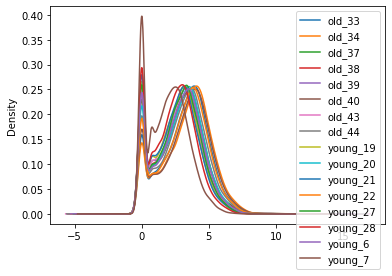

In [26]:
np.log(test+1).plot(kind='kde')

## single-cell DE

In [5]:
import scanpy as sc

In [6]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
res = pd.concat([pd.read_csv(rna_path, sep='\t') for rna_path in rna_list], axis=1) #open and merge datasets
X = res.T
var = pd.DataFrame(X.columns).set_index(0)
var['symbol'] = X.columns

KeyboardInterrupt: 

In [ ]:
anndata = sc.AnnData(X=X, obs=ann.loc[X.index], dtype=float)

In [101]:
anndata.write(filename='/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

... storing 'nGene' as categorical
... storing 'nUMI' as categorical
... storing 'cluster' as categorical
... storing 'animal_type' as categorical
... storing 'cell_classes' as categorical
... storing 'cell_type_age' as categorical
... storing 'miceID' as categorical
... storing 'ageID' as categorical


In [8]:
anndata = sc.read_h5ad('/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

In [9]:
#below DE analysis with diffxpy
import diffxpy.api as de

2023-04-18 13:15:53.627336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 13:15:54.016627: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 13:15:54.096096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 13:15:54.096128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [10]:
anndata.obs.columns

Index(['NAME', 'nGene', 'nUMI', 'cluster', 'animal_type', 'cell_classes',
       'cell_type_age', 'miceID', 'ageID'],
      dtype='object')

In [11]:
anndata.obs['cell_type_age'].unique().tolist()

['MG_young',
 'NEUT_young',
 'DC_young',
 'MAC_young',
 'OLG_young',
 'OPC_young',
 'OEG_young',
 'mNEUR_young',
 'NendC_young',
 'ImmN_young',
 'ABC_young',
 'VLMC_young',
 'EC_young',
 'VSMC_young',
 'ASC_young',
 'NSC_young',
 'ARP_young',
 'NRP_young',
 'PC_young',
 'Hb_VC_young',
 'CPC_young',
 'TNC_young',
 'EPC_young',
 'MNC_young',
 'HypEPC_young',
 'MG_old',
 'DC_old',
 'MAC_old',
 'OLG_old',
 'OPC_old',
 'OEG_old',
 'mNEUR_old',
 'NendC_old',
 'ImmN_old',
 'ABC_old',
 'VLMC_old',
 'EC_old',
 'VSMC_old',
 'ASC_old',
 'NSC_old',
 'ARP_old',
 'PC_old',
 'Hb_VC_old',
 'CPC_old',
 'TNC_old',
 'EPC_old',
 'MNC_old',
 'NEUT_old',
 'NRP_old',
 'HypEPC_old']

In [73]:

#cross = [x + '_' + y for x,y in zip(anndata.obs['animal_type'].tolist(), anndata.obs['miceID'].tolist())]
#anndata.obs['age_miceID'] = cross

subset = anndata.obs[anndata.obs['cell_type_age'].isin(['mNEUR_young', 'mNEUR_old'])].index
# subset = anndata.obs[anndata.obs['cell_type_age'].isin(['ASC_young', 'ASC_old'])].index
# subset = anndata.obs[anndata.obs['cell_type_age'].isin(['MAC_young', 'MAC_old', 
#                                                         'MNC_young', 'MNC_old', 
#                                                         'NEUT_young', 'NEUT_old', 
#                                                         'VLMC_young', 'VLMC_old',
#                                                         'VSMC_young', 'VSMC_old',
#                                                         'EC_young', 'EC_old',
#                                                         'CPC_young', 'CPC_old'
#                                                        ])].index
annsub = anndata[subset, :]

In [74]:
annsub.obs.miceID.value_counts().sum()

5135

In [75]:
yng_means = annsub.X[annsub.obs['animal_type']=='young'].mean(0)
old_means = annsub.X[annsub.obs['animal_type']=='old'].mean(0)

In [69]:
# import patsy
# pat = patsy.dmatrix(formula_like="~ 1 + animal_type + miceID", data=anndata.obs, return_type='dataframe')
# pat.shape
# np.linalg.matrix_rank(pat)

In [30]:
# de.utils.preview_coef_names(
#     sample_description=anndata.obs,
#     formula="~ 1 + animal_type"
# )

In [ ]:
# test = de.test.wald(
#     data=annsub,
#     formula_loc="~1 + animal_type",
#     factor_loc_totest="animal_type",
# )

In [76]:
test_2s = de.test.two_sample(
    data=annsub, 
    grouping="animal_type",
    test="t_test"
)

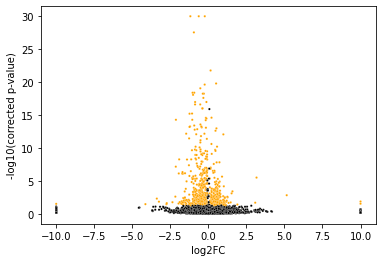

In [69]:
test_2s.summary().sort_values('log2fc')
test_2s.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=5)

In [ ]:
res = test_2s.summary()
res

In [ ]:
res['yng_mean'] = yng_means
res['old_mean'] = old_means

In [ ]:
# dr = res[(res.log2fc < 0)].sort_values('pval').gene[:10].values.tolist()
# ur = res[(res.log2fc > 0)].sort_values('pval').gene[:10].values.tolist()
# top = ur + dr
# res[res.gene=='Pisd']

In [72]:
res.to_csv('subdata/scDE_Neur_results_GSE129788_old::young.csv')

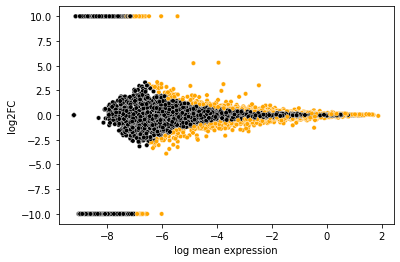

In [64]:
test_2s.plot_ma()